<a href="https://colab.research.google.com/github/vlozg/aicovid/blob/main/%5BTorch007_base%5D_AICOVID_115M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trong thí nghiệm trước, mình hầu hết tập trung vào engineering để có thể chạy được từ đầu tới cuối, đồng thời cũng có thể log lên online để tránh việc có vấn để xảy ra (colab shutdown notebook) gây mất metrics. Về mặt thử nghiệm mô hình, mình không thử được nhiều nhưng phát hiện ra rằng sử dụng SGD mô hình hội tụ tốt hơn dùng Adam.

Các vấn đề tồn đọng cho tới hiện tại:
- Chunking khiến lượng data bùng nổ.

In [ ]:
#@title Cài các thư viện bổ sung.
#@markdown (note: cài xong phải restart runtime, or not?)

#@markdown Các thư viện bổ sung bao gồm:
#@markdown - PyDrive2 (để upload file có kích thước lớn lên GDrive)
#@markdown - torchaudio
#@markdown - Pytorch Lightning
#@markdown - Neptune client (để tạo logger coi online, tránh phải ngồi canh và backup thủ công khi dùng tensor board)

try:
  import torchaudio
except ImportError:
  !pip install PyDrive2
  !pip install torchaudio
  !pip install pytorch-lightning==1.3.8
  !pip install 'neptune-client[pytorch-lightning]'
  # exit()

     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 3.2 MB 8.9 MB/s 
     |████████████████████████████████| 1.9 MB 4.1 MB/s 
     |████████████████████████████████| 813 kB 4.2 MB/s 
     |████████████████████████████████| 829 kB 42.9 MB/s 
     |████████████████████████████████| 234 kB 49.0 MB/s 
     |████████████████████████████████| 10.6 MB 38.7 MB/s 
     |████████████████████████████████| 118 kB 53.9 MB/s 
     |████████████████████████████████| 636 kB 42.4 MB/s 
     |████████████████████████████████| 1.3 MB 37.3 MB/s 
     |████████████████████████████████| 142 kB 50.5 MB/s 
     |████████████████████████████████| 294 kB 53.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=05691122c451b824ae822b5357cb894abc44c6796af4eeab3ecb54b6018e6c7f
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall:

In [ ]:
#@title Lấy xác thực google để upload/download file
#@markdown Vui lòng bấm vào link khi được yêu cầu và lấy mã để nhập vào

# Xác thực google để upload/download qua google drive
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

class GDrive():
    def __init__(self):
        self._gauth = GoogleAuth()
        self._gauth.credentials = self._get_creds()
        self._drive = GoogleDrive(self._gauth)

    def _get_creds(self):
        auth.authenticate_user()
        return GoogleCredentials.get_application_default()

    def Refresh_Auth(self):
        self._gauth.credentials = self._get_creds()

    def SearchInFolder(self, parent_id, file_name):
        self.Refresh_Auth()
        return self._drive.ListFile({'q': f"'{parent_id}' in parents and title = '{file_name}'"}).GetList()

    def CreateFile(self, file_name=None, parent_id=None):
        self.Refresh_Auth()
        file = self._drive.CreateFile({'title': file_name, 
                                       'parents': [{'id': parent_id}]})
        return file

    def Upload(self, file_path, parent_id, file_name=None):
        if file_name == None:
          file_name = file_path.split('/')[-1]
        # Kiểm tra file tồn tại
        file_list = self.SearchInFolder(parent_id, file_name)
        if len(file_list) > 1:
          for file in file_list:
            print('title: %s, id: %s' % (file['title'], file['id']))
          raise NameError('More than 1 file with same name exist, please resolve this')
        
        elif len(file_list) == 0:
          # File chưa có thì tạo mới
          file = self.CreateFile(file_name, parent_id)
        else:
          # Tồn tại duy nhất 1 file
          file = file_list[0]
        
        file.SetContentFile(file_path)
        file.Upload()

    def Download(self, file_name, parent_id):
        # Kiểm tra file tồn tại
        file_list = self.SearchInFolder(parent_id, file_name)
        if len(file_list) > 1:
            for file in file_list:
                print('title: %s, id: %s' % (file['title'], file['id']))
            raise NameError('More than 1 file with same name exist, please resolve this')
        elif len(file_list) == 0:
            raise NameError(f'File named {file_name} not exist')
        else:
            # Tồn tại duy nhất 1 file
            file = file_list[0]
        
        file.GetContentFile(file_name)

drive = GDrive()

In [ ]:
from getpass import getpass

#@title Nhập Neptune API token
api_token = getpass('Enter your private Neptune API token: ')

Enter your private Neptune API token: ··········


# Detect COVID-19 patients via forced-cough cell phone recording

- **Bài toán**: Nhận diện người nhiễm COVID-19 qua tiếng ho ép buộc
    - **Input**: Đoạn ghi âm tiếng ho, tuổi và giới tính
    - **Output**: Phân loại người nhiễm bệnh hay không

## Tìm hiểu bài toán 
Qua paper (https://dspace.mit.edu/bitstream/handle/1721.1/128954/09208795.pdf?sequence=1&isAllowed=y)

# Các biến thiết lập cho thử nghiệm

In [ ]:
# Nếu muốn train mô hình thì set thành True
train_mode = True #@param {type:"boolean"}
experiment_id = '007' #@param {type:"string"}
val_split = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}

In [ ]:
# ID của folder lưu model trên drive
model_zoo = 'secret'
# ID của folder chứa submission
submission_folder = 'secret'
# Tên của file nén để nộp
zip_name = f'Torch_ver{experiment_id}'
# ID của folder chứa data đã preprocess
datadump_folder = 'secret'

# Setup
Import thư viện, tải data, đọc data, tạo helper function,...

## Import thư viện

In [ ]:
# Quản lý file, folder
import os

# Xử lý audio
import torchaudio

# Hiện audio nghe thử
import IPython.display as ipd
from IPython.display import Audio, display
from tqdm import tqdm

import random
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pytorch_lightning as pl

pl.utilities.seed.seed_everything(seed=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Global seed set to 1


device(type='cuda')

## Tải dữ liệu
Bao gồm: warmup (public train, public test, private set)

In [ ]:
#@markdown ## Warmup data:

# download public train data
# official link: https://drive.google.com/file/d/1MPhz3zYl2yefCq-J5XySbFJt99BfKIZD/view
# personal link: https://drive.google.com/file/d/1hoGLxjLmPY-pX-jSVGIaWIZhovQBMKU1/view?usp=sharing
#@markdown - Public train:
is_download = True #@param {type:"boolean"}
train_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_public_train.zip'):
    !gdown --id 1MPhz3zYl2yefCq-J5XySbFJt99BfKIZD
    !unzip -o -q aicv115m_public_train.zip
    !unzip -n -q aicv115m_public_train/train_audio_files_8k.zip
  train_meta = pd.read_csv('aicv115m_public_train/metadata_train_challenge.csv')
  train_meta['file_path'] = 'train_audio_files_8k/'+train_meta['file_path']

# dowload public test data
# official link: https://drive.google.com/file/d/1UrMudzopA3CyR1Ih2J63Kfi2mY_0uhRK/view
# personal link: https://drive.google.com/file/d/1X7vOjHos9f9w48-iTWyu5JElFqCjcH_R/view?usp=sharing
#@markdown - Public test:
is_download = True #@param {type:"boolean"}
test_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_public_test.zip'):
    !gdown --id 1UrMudzopA3CyR1Ih2J63Kfi2mY_0uhRK
    !unzip -o -q aicv115m_public_test.zip
    !unzip -n -q aicv115m_public_test/public_test_audio_files_8k.zip
  test_meta = pd.read_csv('aicv115m_public_test/metadata_public_test.csv')
  test_meta['file_path'] = 'public_test_audio_files_8k/'+test_meta['file_path']

# download private test data
# official link: https://drive.google.com/file/d/1hP8rHwJ_bz3J1T4MtEEp53ZBe9fdFKrW/view
# personal link: https://drive.google.com/file/d/1Ec64sSm2dZqe3da_LVyE_jUBD0DnLyqB/view?usp=sharing
#@markdown - Private test:
is_download = True #@param {type:"boolean"}
private_test_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_private_test.zip'):
    !gdown --id 1Ec64sSm2dZqe3da_LVyE_jUBD0DnLyqB
    !unzip -o -q aicv115m_private_test.zip
  private_test_meta = pd.read_csv('aicv115m_private_test/metadata_private_test.csv')
  private_test_meta['file_path'] = 'aicv115m_private_test/private_test_audio_files_8k/'+private_test_meta['file_path']

#
# Warmup
#
##################################################################################
#
# Final
#
#@markdown ## Final data:

# dowload final train data
# official link: https://drive.google.com/file/d/1Oq9UgA9cEGMNRGvF7oNKkFOg6udsDprl/view
# personal link: https://drive.google.com/file/d/1HoRJllAfYNeBPoCz2nXkf7lQ3raPcFYf/view?usp=sharing
#@markdown - Public train:
is_download = True #@param {type:"boolean"}
final_train_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_final_public_train.zip'):
    !gdown --id 1HoRJllAfYNeBPoCz2nXkf7lQ3raPcFYf
    !unzip -o -q aicv115m_final_public_train.zip
  final_train_meta = pd.read_csv('aicv115m_final_public_train/public_train_metadata.csv')
  final_train_meta['file_path'] = 'aicv115m_final_public_train/public_train_audio_files/'+final_train_meta['uuid']+'.wav'

# download final public test data
# official link: https://drive.google.com/file/d/159SghfGeqVj3AfgTRZXsAAAj0-3ogccX/view
# personal link: https://drive.google.com/file/d/1w5N5prH-uWqLvoSZnuY8TIqm_BBgN2ND/view?usp=sharing
#@markdown - Public test:
is_download = True #@param {type:"boolean"}
final_test_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_final_public_test.zip'):
    !gdown --id 1w5N5prH-uWqLvoSZnuY8TIqm_BBgN2ND
    !unzip -o -q aicv115m_final_public_test.zip
  print("Warning: final public test set doesn't have metadata.")
  final_test_meta = pd.read_csv('aicv115m_final_public_test/public_test_sample_submission.csv').drop("assessment_result", axis=1)
final_test_meta['file_path'] = 'aicv115m_final_public_test/public_test_audio_files/'+final_test_meta['uuid']+'.wav'

## Setup thư mục chứa data và đọc meta

In [ ]:
display(train_meta.shape)
train_meta.head()

(1199, 5)

,uuid,subject_gender,subject_age,assessment_result,file_path
0,3284bcf1-2446-4f3a-ac66-14c76b294177,male,23.0,0,train_audio_files_8k/3284bcf1-2446-4f3a-ac66-1...
1,431334e1-5946-4576-bb51-8e342ccc22b4,NaN,NaN,0,train_audio_files_8k/431334e1-5946-4576-bb51-8...
2,1d6fac4b-1e7f-4bdc-81cd-3a720bfbb1e1,NaN,NaN,0,train_audio_files_8k/1d6fac4b-1e7f-4bdc-81cd-3...
3,c7ee0695-b2e7-4beb-b904-f1455c9609d9,male,49.0,0,train_audio_files_8k/c7ee0695-b2e7-4beb-b904-f...
4,dd541704-b696-4181-8fd8-816daac0fcf9,NaN,NaN,0,train_audio_files_8k/dd541704-b696-4181-8fd8-8...


In [ ]:
display(test_meta.shape)
test_meta.head()

(350, 4)

,uuid,subject_gender,subject_age,file_path
0,66ef1f05-fbb0-44cb-8bdb-8eb4df83359a,female,28.0,public_test_audio_files_8k/66ef1f05-fbb0-44cb-...
1,73d13a12-f9bc-4554-af49-be24f6024a25,NaN,NaN,public_test_audio_files_8k/73d13a12-f9bc-4554-...
2,d27dbe98-e061-4018-9900-d1f1d47feab1,NaN,NaN,public_test_audio_files_8k/d27dbe98-e061-4018-...
3,43c30e4c-5d35-4ebc-8235-8920b7688550,female,NaN,public_test_audio_files_8k/43c30e4c-5d35-4ebc-...
4,1952aa84-d077-495d-a1a9-9686a30722e0,female,NaN,public_test_audio_files_8k/1952aa84-d077-495d-...


In [ ]:
display(private_test_meta.shape)
private_test_meta.head()

(450, 4)

,uuid,subject_gender,subject_age,file_path
0,bce020a3-6ab7-46df-8a75-7f8009a1883e,NaN,NaN,aicv115m_private_test/private_test_audio_files...
1,efe397fd-5ff1-41d8-b991-b8acdafd663c,male,45.0,aicv115m_private_test/private_test_audio_files...
2,5954077a-4c41-4a2e-9cad-e3bb2d6402c4,female,27.0,aicv115m_private_test/private_test_audio_files...
3,2b330c25-0816-480a-bb87-9d3d0d632c0c,NaN,NaN,aicv115m_private_test/private_test_audio_files...
4,bfa78793-b3b8-42b8-bad0-77e3c55abfda,NaN,NaN,aicv115m_private_test/private_test_audio_files...


In [ ]:
display(final_train_meta.shape)
final_train_meta.head()

(4504, 7)

,uuid,subject_age,subject_gender,audio_noise_note,cough_intervals,assessment_result,file_path
0,fc802bee-ef01-4496-a898-d7e77c0017e9,group_34_48,male,NaN,NaN,0,aicv115m_final_public_train/public_train_audio...
1,9341db3f-049a-4ceb-8438-87ca1618a18a,group_34_48,male,NaN,"[{'start': 1.9051594202898552, 'end': 2.414901...",0,aicv115m_final_public_train/public_train_audio...
2,307e7a8b-b312-409e-ac01-75e1260b0a95,group_19_33,male,NaN,NaN,0,aicv115m_final_public_train/public_train_audio...
3,ff8c21a8-4d05-43d8-96ee-dd33bcd6461e,group_19_33,male,NaN,"[{'end': 1.516455486542442, 'start': 1.1739296...",0,aicv115m_final_public_train/public_train_audio...
4,2e9d68e1-e84e-4aa5-8199-e7b0bbe6969f,group_19_33,male,NaN,NaN,0,aicv115m_final_public_train/public_train_audio...


In [ ]:
display(final_test_meta.shape)
final_test_meta.head()

(1233, 2)

,uuid,file_path
0,7b3797b0-3b7e-41e3-8b28-e2717eb55f8b,aicv115m_final_public_test/public_test_audio_f...
1,f0c466b3-7bf2-47e4-9e7f-f8cfc1783764,aicv115m_final_public_test/public_test_audio_f...
2,a2d668e9-d876-4bf6-bcb3-0cc32ba20c84,aicv115m_final_public_test/public_test_audio_f...
3,0edbea61-da70-44a4-8ee8-3681027944a6,aicv115m_final_public_test/public_test_audio_f...
4,1bcee200-1c33-4293-b1e9-5854210d92e8,aicv115m_final_public_test/public_test_audio_f...


## Hàm xử lý âm thanh

In [ ]:
#@markdown ## Các hàm vỏ bọc cho đọc file
#@markdown `read_audio(path)`: vỏ bọc cho `torchaudio.load(path)`.<br>
#@markdown `read_resample_audio(path)`: chỉ trả về wave vì sample rate đã được cố định.

'''
  Read audio from given path and return (wave, sample_rate)
'''
def read_audio(full_audio_path):
  return torchaudio.load(full_audio_path)

'''
  Read audio from given path, then resample if sample rate is not matched 
  and return wave.

  Tips: 
    you should provide resampler from torchaudio.transform
    when batch resampling with same params since this can
    give a huge speed up.
'''
def read_resample_audio(
    full_audio_path, resample,
    resampler=None
):
  wave, sr = torchaudio.load(full_audio_path)
  if resampler is not None:
      wave = resampler(wave)
  elif sr != resample:
      wave = torchaudio.functional.resample(wave, sr, resample)
  return wave

### Audio features

In [ ]:
# Spectrogram transformation
n_fft = 2048
win_length = 160
hop_length = 80
n_mels = 200
n_mfcc = 200

In [ ]:
#@markdown `spectrogram(waveform)` --> spec 
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    normalized=True,
    pad_mode="reflect",
    power=2.0,
)

#@markdown `mel_spectrogram(waveform)` --> mel_spec 
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    #norm='slaney',
    onesided=True,
    normalized=True,
    n_mels=n_mels,
    mel_scale="htk",
)

#@markdown `log_spectrogram(spec)` --> log(spec)
log_spectrogram = torchaudio.transforms.AmplitudeToDB(
    stype='power',
    top_db=80
)

#@markdown `mfcc_transform(waveform)` --> mfcc
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=8000,
    n_mfcc=n_mfcc,
    log_mels=False,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'win_length': win_length,
    }
)

#@markdown `delta_transform(spec)` --> delta 1
delta_transform = torchaudio.transforms.ComputeDeltas(
    win_length = 5, 
    mode = 'replicate'
)

### Augmentation cho audio
Bao gồm: thêm noise (nhiều mức độ), SpecAugment, chunking

In [ ]:
#@markdown `AudioChunking(chunk_size=400, chunk_step=200)`
class AudioChunking(torch.nn.Module):
    def __init__(self,
                 chunk_size: int=400,
                 chunk_step: int=200) -> None:
        super(AudioChunking, self).__init__()
        self.chunk_size = chunk_size
        self.chunk_step = chunk_step
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        _, _, spec_len = spec.shape
        pad_size = self.chunk_size - spec_len%self.chunk_size
        pad_size = (pad_size//2, pad_size//2+pad_size%2)
        padded_spec = torch.nn.functional.pad(spec, pad_size, mode='constant', value=0)
        chunks = padded_spec.unfold(-1, self.chunk_size, self.chunk_step).permute(2,0,1,3)
        return chunks

In [ ]:
#@markdown `SpecAugment(time_W=50, freq_W=50, T=80, F=80)`
def _h_poly(t):
    tt = t.unsqueeze(-2)**torch.arange(4, device=t.device).view(-1,1)
    A = torch.tensor([
        [1, 0, -3, 2],
        [0, 1, -2, 1],
        [0, 0, 3, -2],
        [0, 0, -1, 1]
    ], dtype=t.dtype, device=t.device)
    return A @ tt


def _cspline_interpolate(x, y, xs):
    '''
    Input x and y must be of shape (batch, n) or (n)
    '''
    m = (y[..., 1:] - y[..., :-1]) / (x[..., 1:] - x[..., :-1])
    m = torch.cat([m[...,[0]], (m[...,1:] + m[...,:-1]) / 2, m[...,[-1]]], -1)
    idxs = torch.searchsorted(x[..., 1:], xs)
    dx = (x.take_along_dim(idxs+1, dim=-1) - x.take_along_dim(idxs, dim=-1))
    hh = _h_poly((xs - x.take_along_dim(idxs, dim=-1)) / dx)
    return hh[...,0,:] * y.take_along_dim(idxs, dim=-1) \
        + hh[...,1,:] * m.take_along_dim(idxs, dim=-1) * dx \
        + hh[...,2,:] * y.take_along_dim(idxs+1, dim=-1) \
        + hh[...,3,:] * m.take_along_dim(idxs+1, dim=-1) * dx
        

class SpecAugment(torch.nn.Module):
  def __init__(
      self,
      time_W: int = 0,
      freq_W: int = 0,
      T: int = 0,
      F: int = 0,
      mT: int = 1,
      mF: int = 1
  ) -> None:
      super(SpecAugment, self).__init__()
      self.identity_fn = lambda x: x
      self.time_W = time_W
      self.freq_W = freq_W
      if time_W==0 and freq_W==0:
          self.cum_warping = lambda x: x
      elif time_W!=0 and freq_W==0:
          self.cum_warping = self.time_warping
      elif time_W==0 and freq_W!=0:
          self.cum_warping = self.freq_warping
      else:
          self.cum_warping = self.time_freq_warping
      self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=T) if T>0 else self.identity_fn
      self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=F) if F>0 else self.identity_fn


  def _get_warping_flow(self,
                        warp_p: torch.Tensor,
                        warp_d: torch.Tensor,
                        interp_len: int) -> torch.Tensor:
      '''
      Get interpolated flow
      Warning: This function doesn't check for batch size match between warp_p and warp_d
      '''
      device = warp_p.device
      batch_size = warp_p.shape[0]

      src_control_points = torch.stack([torch.tensor([0], device=device).expand(batch_size),
                                        warp_p, torch.tensor([interp_len-1], device=device).expand(batch_size)], dim=1)
      dest_control_points = torch.stack([torch.tensor([-1.], device=device).expand(batch_size),
                                        (warp_p-warp_d)*2/(interp_len-1)-1, torch.tensor([1], device=device).expand(batch_size)], dim=1)

      # Interpolate from 3 points to interp_len points
      src_interp_points = torch.linspace(0, interp_len-1, interp_len, device=device).unsqueeze(0).expand(batch_size, -1)
      dest_interp_points = _cspline_interpolate(src_control_points, dest_control_points, src_interp_points)

      return dest_interp_points


  def freq_warping(self, specs: torch.Tensor) -> torch.Tensor:
      '''
      Frequency warping augmentation, only return interpolated flow

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
      '''
      W = self.freq_W
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      warp_p = torch.randint(W, num_freqs - W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      warp_d = torch.randint(-W, W, (batch_size,), device=device)
      
      dest_freq_points = self._get_warping_flow(warp_p, warp_d, num_freqs)
      dest_frame_points = torch.linspace(-1, 1, num_frames, device=device)

      grid = torch.cat(
          (dest_frame_points.view(-1,1).expand(batch_size,num_freqs,-1,-1),
          dest_freq_points.view(batch_size,-1,1,1).expand(-1,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def time_warping(self, specs: torch.Tensor) -> torch.Tensor:
      '''
      Time warping augmentation, only return interpolated flow

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
      '''
      W = self.time_W
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      warp_p = torch.randint(W, num_frames - W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      warp_d = torch.randint(-W, W, (batch_size,), device=device)

      # Interpolate from 3 points to num_frames points
      dest_frame_points = self._get_warping_flow(warp_p, warp_d, num_frames)
      dest_freq_points = torch.linspace(-1, 1, num_freqs, device=device)

      grid = torch.cat(
          (dest_frame_points.view(batch_size,1,-1,1).expand(-1,num_freqs,-1,-1),
          dest_freq_points.view(-1,1,1).expand(batch_size,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def time_freq_warping(self,specs: torch.Tensor) -> torch.Tensor:
      '''
      Doing both time warping and frequency warping augmentation

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
        W: strength of warp
      '''
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      time_warp_p = torch.randint(self.time_W, num_frames - self.time_W, (batch_size,), device=device)
      freq_warp_p = torch.randint(self.freq_W, num_freqs - self.freq_W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      time_warp_d = torch.randint(-self.time_W, self.time_W, (batch_size,), device=device)
      freq_warp_d = torch.randint(-self.freq_W, self.freq_W, (batch_size,), device=device)

      # Interpolate lên theo kích thước spec
      dest_freq_points = self._get_warping_flow(freq_warp_p, freq_warp_d, num_freqs)
      dest_frame_points = self._get_warping_flow(time_warp_p, time_warp_d, num_frames)

      grid = torch.cat(
          (dest_frame_points.view(batch_size,1,-1,1).expand(-1,num_freqs,-1,-1),
          dest_freq_points.view(batch_size,-1,1,1).expand(-1,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def forward(self, specs: torch.Tensor) -> torch.Tensor:
      aug_specs = self.cum_warping(specs)
      aug_specs = self.time_masking(aug_specs)
      aug_specs = self.freq_masking(aug_specs)
      return aug_specs

In [ ]:
#@markdown Tải noise audio
import requests

!mkdir _sample_data
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join('_sample_data', "bg.wav")
SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join('_sample_data', "rir.wav")

def _fetch_data():
  uri = [
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH)
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

In [ ]:
def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

In [ ]:
import math

#@markdown `RoomReverb`, `NoiseInject`, `PhoneSim`
class RoomReverb(torch.nn.Module):
    def __init__(self, rir_list):
        super(RoomReverb, self).__init__()
        self.rirs = rir_list

    def _get_rir(self):
        if type(self.rirs) is list:
            return random.choice(self.rirs)
        else: 
            return next(self.rirs)

    def forward(self, wave: torch.Tensor):
        rir = self._get_rir()
        _wave = torch.nn.functional.pad(wave, (rir.shape[-1]-1, 0))
        _wave = torch.nn.functional.conv1d(_wave[None, ...], rir[None, ...])[0]
        return _wave


class NoiseInject(torch.nn.Module):
    def __init__(self, noise_list, snr_db):
        super(NoiseInject, self).__init__()
        self.noises = noise_list
        self.snr_db = snr_db

    def _get_noise(self):
        if type(self.noises) is list:
            return random.choice(self.noises)
        else: 
            return next(self.noises)

    def forward(self, wave: torch.Tensor):
        noise = self._get_noise()
        _noise = noise.repeat(1, 1 + wave.shape[-1] // noise.shape[-1])[..., :wave.shape[-1]]
        scale = math.exp(self.snr_db / 10) * _noise.norm(p=2) / wave.norm(p=2)
        _wave = (scale * wave + _noise) / 2
        return _wave


class PhoneSim(torch.nn.Module):
    def __init__(self):
        super(PhoneSim, self).__init__()

    def forward(self, wave: torch.Tensor):
        device = wave.device
        _wave = wave.cpu()
        _wave, _ = torchaudio.sox_effects.apply_effects_tensor(
          _wave, 8000,
          effects=[["lowpass", "4000"],
                   ["compand", "0.02,0.05", "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8", "-8", "-7", "0.05"]]
        )
        _wave = torchaudio.functional.apply_codec(_wave, 8000, format="gsm")
        return _wave.to(device)

In [ ]:
rir, _ = get_rir_sample(resample=8000, processed=True)
noise, _ = get_noise_sample(resample=8000)

In [ ]:
#@markdown `StandardScaler()`
class StandardScaler(torch.nn.Module):
    def __init__(self) -> None:
        super(StandardScaler, self).__init__()
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return ((spec-spec.mean())/spec.std()).nan_to_num(posinf=0.0, neginf=0.0)

#@markdown `MinMaxScaler()`
class MinMaxScaler(torch.nn.Module):
    def __init__(self, min=None, max=None) -> None:
        super(MinMaxScaler, self).__init__()
        if min:
            self._min = lambda x: min
        else:
            self._min = lambda x: x.min()
        if max:
            self._max = lambda x: max
        else:
            self._max = lambda x: x.max()
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return ((spec-self._min(spec))/(self._max(spec)-self._min(spec))).nan_to_num(posinf=0.0, neginf=0.0)

## Các hàm bổ trợ trực quan

In [ ]:
#@markdown Vẽ specgram `plot_specgram(wave, sr, title, xlim, ylim)`
#@markdown (specgram chỉ đơn giản là apply discrete-time Fourier transform)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  # Tensor --> Numpy
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]

  # Plot specgram for each channel
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)



#@markdown Vẽ waveform `plot_waveform(wave, sr, title, xlim, ylim)`

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  # Tensor --> Numpy
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]

  # Plot waveform for each channel
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)



#@markdown Vẽ spectrogram `plot_spectrogram(spec, axs, title, ylabel, aspect, xmax)`

def plot_spectrogram(spec, fig=None, axs=None, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  if axs is None:
    fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(log_spectrogram(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)



#@markdown Hiển thị audio box `play_audio(wave, sr)`

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Function for preparing dataset/dataloader

## Tách validation set

In [ ]:
from sklearn.model_selection import train_test_split

idx_train, idx_val = train_test_split(final_train_meta.index,train_size=val_split)

val_meta = final_train_meta.iloc[idx_val]
train_meta = final_train_meta.iloc[idx_train]

display(len(train_meta))
display(len(val_meta))

3603

901

## Dataset class

In [ ]:
#@title Class `AICOVIDDataset`
import tempfile, shutil
import weakref
import pickle

class AICOVIDDataset(Dataset):
    def __init__(self, 
                 meta_df: pd.DataFrame=None, 
                 audio_transforms: torch.nn.ModuleList=None, 
                 chunking: torch.nn.Module=None) -> None:
        
        # Create temporary folder to dump preprocessed data
        self._temp_folder = tempfile.mkdtemp()
        self._finalizer = weakref.finalize(self, shutil.rmtree, self._temp_folder)

        self.meta_df = meta_df
        self.file_paths = []
        self.idxs = [] 
        
        if meta_df is None: return  # Allow empty dataset for loading from gdrive later

        for id, file in enumerate(self.meta_df['file_path']):
            specs = self._read_spec_audio(file, audio_transforms)
            if chunking:
                for spec in specs:
                    paths = self._dump_to_disk(chunking(spec))
                    self.file_paths += paths
                    self.idxs += [id]*len(paths)
            else:
                paths = self._dump_to_disk(specs)
                self.file_paths += paths
                self.idxs += [id]*len(paths)

        # Pickle for backup later
        with open(f"{self._temp_folder}/meta_df.pkl",'wb') as tmp:
            pickle.dump(self.meta_df, tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'wb') as tmp:
            pickle.dump(self.file_paths, tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'wb') as tmp:
            pickle.dump(self.idxs, tmp)
            

    def _read_spec_audio(self, 
                         file: str,
                         transforms: torch.nn.ModuleList=None) -> list:
        wave = read_resample_audio(file, 8000).cuda()
        if transforms:
            specs = [trans(wave) for trans in transforms]
        else:
            specs = [wave]
        return specs

    def _dump_to_disk(self, specs: list or torch.Tensor) -> list:
        file_paths = []
        for spec in specs:
            fd, path = tempfile.mkstemp(suffix=".pt", dir=self._temp_folder)
            with os.fdopen(fd, 'wb') as tmp:
                # Clone to prevent view preserving of PyTorch
                # also moving tensor to cpu so when load up
                # pytorch will not moving them to gpu bebforehand!
                torch.save(spec.cpu(), tmp)
            file_paths.append(path)
        return file_paths

    def backup_to_drive(self, folder_id: str, upload_name: str):
        if self.meta_df is None:
            raise NamedError("Cannot backup an empty dataset.")
        
        os.system(f'zip -j ./{upload_name} {self._temp_folder}/*')
        drive.Upload(upload_name, folder_id)
        os.remove(upload_name)


    def load_from_drive(self, folder_id: str, backuped_name: str):
        drive.Download(backuped_name, folder_id)
        os.system(f'unzip -o {backuped_name} -d {self._temp_folder}')
        os.remove(backuped_name)
        with open(f"{self._temp_folder}/meta_df.pkl",'rb') as tmp:
            self.meta_df = pickle.load(tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'rb') as tmp:
            self.idxs = pickle.load(tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'rb') as tmp:
            self.file_paths = pickle.load(tmp)
        # Replace old tmp dir with current tmp dir
        for i, path in enumerate(self.file_paths):
            self.file_paths[i] = self._temp_folder+'/'+path.split('/')[-1]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spec = torch.load(self.file_paths[idx])
        meta = self.meta_df.iloc[self.idxs[idx]]
        try:
            label = torch.tensor(meta['assessment_result'])
        except KeyError:
            label = None
        try:
            id = meta['uuid']
            gender = meta['subject_gender']
            age = meta['subject_age']

            return spec, label, id, gender, age
        except KeyError:
            return spec, None, None, None, None

## Collate function

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_pad_seq_fn(batch):
    # A data tuple has the form:
    # spec, label

    specs, labels = [], []

    # Gather in lists, and encode labels as indices
    for spec, label, _, _, _ in batch:
        specs += [spec.permute(2,0,1)]
        labels += [label]

    # Group the list of tensors into a batched tensor
    specs = pad_sequence(specs, batch_first=True).permute(0,2,3,1)
    try:
      labels = torch.stack(labels)
      return specs, labels
    except:
      return specs

In [ ]:
def collate_fn(batch):
    # A data tuple has the form:
    # spec, label

    specs, labels = [], []

    # Gather in lists, and encode labels as indices
    for spec, label, _, _, _ in batch:
        specs += [spec]
        labels += [label]

    # Group the list of tensors into a batched tensor
    specs = torch.stack(specs)
    try:
      labels = torch.stack(labels)
      return specs, labels
    except:
      return specs

# Lightning module

In [ ]:
class AICOVIDModule(pl.LightningModule):
    def __init__(self, model, optim_config: dict, augment=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.augment = augment
        self.optim_config = optim_config
        self.ce_loss = nn.CrossEntropyLoss(torch.tensor([0.2, 0.8], device=self.device))


    ################################################
    # For inference/training forward
    ################################################

    def forward(self, x):
        '''
        Do a forward pass for training/validating
        '''
        return self.model(x).squeeze(-1)

    def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        '''
        Do inference
        '''
        y_hat = self(batch)

        # Apply softmax in case of 2 class (2 node at the end)
        y_hat = torch.softmax(y_hat, dim=-1)[:,1]

        # Apply sigmoid in case of binary (1 node at the end)
        # y_hat = torch.sigmoid(y_hat)
        
        # Không dùng argmax được vì chỉ trả về 1 giá trị
        # y_hat = torch.argmax(y_hat, -1)
        # y_hat = torch.where(y_hat > 0.5, 1, 0)
        # Nếu muốn lấy class thì tự implement, predict_step là API của pl
        
        return y_hat


    ################################################
    # Main function for train/val/test
    ################################################
    
    def loss_fn(self, logits, labels):
        '''
        Calculate loss ~manually since we need to handle autocast~
        '''
        # with torch.cuda.amp.autocast(False):
        #     loss = F.binary_cross_entropy(logits.float(), labels.float())

        loss = self.ce_loss(logits, labels)
        return loss


    def _shared_step(self, xs, ys):
        '''
        Shared step that happened in both train/val step
        '''
        logits = self(xs)
        # negative log-likelihood for a tensor of size (batch x n_output)
        loss = self.loss_fn(logits, ys)
        # take sigmoid of logits to get probs
        logits = torch.softmax(logits, dim=-1)[:,1]
        return loss, logits


    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        if self.augment:
            x = self.augment(x)
        loss, logits = self._shared_step(x, y)
        self.log('train/loss_step', loss)        
        return {'loss': loss, 'probs': logits.detach(), "targets": y}

    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        loss, logits = self._shared_step(x, y)
        return {'loss': loss, 'probs': logits, "targets": y}

    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        loss, logits = self._shared_step(x, y)
        return {'loss': loss, 'probs': logits, "targets": y}


    ################################################
    # Optimizer configuration
    ################################################
    
    def configure_optimizers(self):
        optimizer = self.optim_config['optimizer']
        lr = self.optim_config['lr']
        lrschedule = self.optim_config['scheduler']

        ### SET OPTIMIZER

        if optimizer['type'] == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer['type'] == 'SGD':
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        else:
            raise ValueError(f"Optimizer not implemented: {optimizer}")

        # Number of gradient calculations per epoch
        grad_update_step = math.ceil( len(self.train_dataloader()) / self.trainer.accumulate_grad_batches )
        
        ### SET SCHEDULER
        
        if lrschedule['type'] == "OneCycleLR":
            # OneCycleLR
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=lr, 
                                                             steps_per_epoch=grad_update_step,
                                                             epochs=self.trainer.max_epochs)
        elif lrschedule['type'] == "CosineAnnealingLR":
            # CosineAnnealing
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10*grad_update_step)
        elif lrschedule['type'] == "None":
            # Set constant scheduler to prevent
            self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda epoch: lr)
        else:
            raise ValueError(f"Scheduler not implemented: {lrschedule}")

        ### COMPLETE SETUP

        if self.scheduler:
            sched = {
                'scheduler': self.scheduler,
                'interval': 'step'
            }
            return [self.optimizer], [sched]
        else:
            return self.optimizer

# Callbacks

In [ ]:
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

In [ ]:
#@markdown Upload lightning_logs folder to gdrive (**depricated** since we're using Neptune logger)

class BackupCallback(Callback):
    def _backup(self):
        os.system(f"zip -r ./tmp_lightning_logs_{experiment_id}.zip ./lightning_logs")
        try:
            drive.Upload(f"tmp_lightning_logs_{experiment_id}.zip", model_zoo)
        except:
            print("Upload failed.")

    def on_train_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch+1)%20 == 0:
            self._backup()
            print(f"Lightning logs backuped at epoch {trainer.current_epoch}.")

    def on_train_end(self, trainer, pl_module):
        self._backup()
        print(f"Lightning logs backuped at the end of training.")

In [ ]:
#@markdown Helper function: confusion matrix tensor --> Neptune file
from neptune.new.types import File

def comfmat_to_neptune_html(confmat):
    return File.as_html(pd.DataFrame(confmat.cpu().numpy()))

def comfmat_to_neptune_img(confmat):
    df = pd.DataFrame(confmat.cpu().numpy().astype(int))
    plt.close('all')
    fig = plt.figure(figsize = (7,7))
    fig.add_subplot(sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d"))
    return File.as_image(fig)

In [ ]:
#@markdown Logging metrics to Neptune logger
from torchmetrics import Accuracy, MetricCollection, Precision, Recall, ConfusionMatrix, AUROC, AverageMeter

class LogMetricsNeptune(Callback):
    def __init__(self):
        self.metrics = MetricCollection([Accuracy(compute_on_step=False), 
                                         Precision(compute_on_step=False), 
                                         Recall(compute_on_step=False), 
                                         AUROC(num_classes=2, pos_label=1, compute_on_step=False)])
        self.comfmat = ConfusionMatrix(num_classes=2, compute_on_step=False)
        self.avg_loss = AverageMeter()

    def _setup(self, trainer, pl_module, stage=None):
        # dunno why setup hook not called when I call trainer.test?
        device = pl_module.device
        self.metrics.to(device)
        self.comfmat.to(device)
        self.avg_loss.to(device)

    def on_fit_start(self, trainer, pl_module):
        self._setup(trainer, pl_module, "fit")

    def on_test_start(self, trainer, pl_module):
        self._setup(trainer, pl_module, "test")

    # def on_pretrain_routine_start(self, trainer, pl_module):
    #     device = pl_module.device
    #     self.metrics = MetricCollection([Accuracy(compute_on_step=False), 
    #                                      Precision(compute_on_step=False), 
    #                                      Recall(compute_on_step=False), 
    #                                      AUC(reorder=True, compute_on_step=False)]).to(device)
    #     self.comfmat = ConfusionMatrix(num_classes=2, compute_on_step=False).to(device)
    #     self.avg_loss = AverageMeter().to(device)

    def _update_metrics(self, **kwargs):
        # Prevent autocast since sometime it turn y to float, cause metric raise error...
        probs = kwargs['probs']
        targets = kwargs['targets']
        loss = kwargs['loss']
        with torch.cuda.amp.autocast(False):
            self.metrics(probs, targets)
            self.comfmat(probs, targets)
            self.avg_loss(loss)


    def _log_metrics(self, trainer, type: str):
        comfmat_file = comfmat_to_neptune_img(self.comfmat.compute())
        
        if trainer.logger is None:
            return
        # Catch exception from stopped logger
        try:
            # Log confusion matrix
            trainer.logger.experiment[f'comfmat/{type}/latest'].upload(comfmat_file)
            trainer.logger.experiment[f'comfmat/{type}/series'].log(comfmat_file)
            
            # Log metrics
            trainer.logger.experiment[f'metrics/{type}/loss'].log(self.avg_loss.compute())
            for key, value in self.metrics.compute().items():
                trainer.logger.experiment[f'metrics/{type}/{key}'].log(value)
        except Exception as e:
            if type(e).__name__ == "InactiveRunException":
                print("Warning: Neptune logger has stopped running. Logging couldn't be done.")
            else:
                raise e


    def _print_metrics(self):
        print("Loss: ", self.avg_loss.compute().item())
        for key, value in self.metrics.compute().items():
            print(f"{key}: {value}")
        

    def _reset_metrics(self):
        self.comfmat.reset()
        self.metrics.reset()
        self.avg_loss.reset()


    def on_train_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_train_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "train")
        self._reset_metrics()

    def on_validation_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_validation_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "val")
        self._reset_metrics()

    def on_test_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_test_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "test")
        self._print_metrics()
        self._reset_metrics()

In [ ]:
#@markdown Save last checkpoint to Neptune logger
import glob

class SaveCheckpointNeptune(Callback):
    def __init__(self, interval: int=1):
        self.interval = interval


    def _upload_latest_ckp(self, trainer):
        if trainer.logger is None:
            return
        try:
            ckp_dir = "/".join([trainer.default_root_dir, trainer.logger.name, trainer.logger.version])
            ckp_file = glob.glob(ckp_dir+"/checkpoints/*.ckpt")[0]
            trainer.logger.experiment[f'checkpoints/latest'].upload(ckp_file)
            print(f"{trainer.current_epoch} epoch backuped: {ckp_file}")
        except Exception as e:
            if type(e).__name__ == "InactiveRunException":
                print("Warning: Neptune logger has stopped running. Logging couldn't be done.")
            else:
                raise e


    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch%self.interval != 0:
            return
        self._upload_latest_ckp(trainer)


    def on_train_end(self, trainer, pl_module):
        self._upload_latest_ckp(trainer)

# Models

## NiN ResNet

In [ ]:
from torchvision.models import resnet

class ResNet_NiN(resnet.ResNet):
    def __init__(
        self,
        in_channels,
        **kwargs
    ) -> None:
        super(ResNet_NiN, self).__init__(**kwargs)
        
        # Reinit conv1 to have flexible in channels
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')

        # NiN layer (without Conv2d)
        nin_in_channels = self.fc.in_features
        nin_out_channels = self.fc.out_features
        self.nin = nn.Sequential(
            nn.ReLU(), nn.Conv2d(nin_in_channels, nin_out_channels, kernel_size=1),
            nn.ReLU(), nn.Conv2d(nin_out_channels, nin_out_channels, kernel_size=1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

        # Delete unused layers
        del self.avgpool
        del self.fc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.nin(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)

        return x

## ResNet for classification

In [ ]:
from torchvision.models import resnet

class CustomFCResNet(resnet.ResNet):
    def __init__(
        self,
        in_channels: int,
        fc_layers: list,
        **kwargs
    ) -> None:
        super(CustomFCResNet, self).__init__(**kwargs)
        
        # Reinit conv1 to have flexible number of channels
        if in_channels != 3:
            self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')

        # FC layer
        num_filters = self.fc.in_features
        fc = [nn.Linear(num_filters, fc_layers[0])]
        for i in range(1, len(fc_layers)):
            fc.append(nn.ReLU())
            fc.append(nn.Linear(fc_layers[i-1], fc_layers[i]))
        self.fc = nn.Sequential(*fc)

        # self.avgpool = nn.AdaptiveMaxPool2d((1, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._forward_impl(x)
        return x

# Trainer params

In [ ]:
#@markdown Make a Neptune logger instance `logger(name)`

# from pytorch_lightning.loggers import NeptuneLogger

# logger = lambda ver: NeptuneLogger(
#     api_key=api_token,
#     project_name='vulong61/AICOVID', 
#     experiment_name=f'{experiment_id}_{ver}',  # Optional
# )

#-------------New from neptune-----------------

from neptune.new.integrations.pytorch_lightning import NeptuneLogger

logger = lambda ver: NeptuneLogger(
    api_key=api_token,
    project='vulong61/AICOVID', 
    name=f'{experiment_id}_{ver}',  # Optional
    tags=[],
    close_after_fit=False,
)

In [ ]:
#@title Trainer params
mixed_precision = True #@param {type:"boolean"}
swa = False #@param {type:"boolean"}
max_epochs = 35 #@param {type:"integer"}

#@markdown Dataloader params
batch_size = 128 #@param {type:"integer"}
grad_accum =  1#@param {type:"integer"}

#@markdown Logger name on Neptune.AI
logger_exp_name = "exp009" #@param {type:"string"}

trainer_params = {
    "gpus": 1,
    "precision": 16 if mixed_precision else 32,
    "max_epochs": max_epochs,
    "progress_bar_refresh_rate": 10,
    "accumulate_grad_batches": grad_accum,
    "stochastic_weight_avg": swa,

    "callbacks": [LogMetricsNeptune(),
                  LearningRateMonitor(logging_interval="step"),
                  SaveCheckpointNeptune(10)],

    # flag for debugging
    "track_grad_norm": 2,
    "terminate_on_nan": True,
    "weights_summary": 'full',
}

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:37: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
#@title Optimizer params
lr = 0.02 #@param {type:"number"}
optimizer = "SGD" #@param ["SGD", "Adam"]
scheduler = "OneCycleLR" #@param ["OneCycleLR", "CosineAnnealingLR", "None"]
optim_config = {
    'optimizer': {"type": optimizer,
                  "kawrgs": None},
    'scheduler': {"type": scheduler,
                  "kawrgs": None},
    'lr': lr,
}

# Experiment - Data

## Transformations

Basic feature transform

In [ ]:
# Used in torch006 and before
scaled_melspec_transform = nn.Sequential(mel_spectrogram,
                                         log_spectrogram,
                                         StandardScaler())

# Used in torch007-exp001
scaled_mfcc_transform = nn.Sequential(mfcc_transform,
                                      StandardScaler())

# Used in torch007-exp002
raw_melspec_transform = nn.Sequential(mel_spectrogram,
                                      log_spectrogram)

Transformation with augments

In [ ]:
basic_transform = scaled_melspec_transform

transform0 = nn.Sequential(basic_transform).cuda()
transform1 = nn.Sequential(NoiseInject([noise.cuda()], 8),
                           basic_transform).cuda()
transform2 = nn.Sequential(NoiseInject([noise.cuda()], 16),
                           basic_transform).cuda()
transform3 = nn.Sequential(RoomReverb([rir.cuda()]), 
                           NoiseInject([noise.cuda()], 8), 
                           PhoneSim(),
                           basic_transform).cuda()

## Dataloader

In [ ]:
num_workers=2
pin_memory=True

In [ ]:
train_set = AICOVIDDataset(train_meta, torch.nn.ModuleList([transform0]), chunking=AudioChunking(400, 200))
val_set = AICOVIDDataset(val_meta, torch.nn.ModuleList([transform0]), chunking=AudioChunking(400, 200))
test_set = AICOVIDDataset(val_meta, torch.nn.ModuleList([transform0]))

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    collate_fn=collate_pad_seq_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Experiment - Train

## Train

In [ ]:
exp_logger = logger(logger_exp_name)
# Log hyperparam to logger for convinient
exp_logger.experiment['hyperparam'] = trainer_params
exp_logger.experiment['hyperparam'] = optim_config

resnet18 = CustomFCResNet(in_channels=1, fc_layers=[2], block=resnet.BasicBlock, layers=[2, 2, 2, 2])
model = AICOVIDModule(resnet18, optim_config=optim_config)#, augment=SpecAugment(time_W=100, freq_W=50, T=80))
trainer = pl.Trainer(**trainer_params, logger=exp_logger)

https://app.neptune.ai/vulong61/AICOVID/e/AIC-106
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                        | Type              | Params
-------------------------------------------------------------------
0  | model                       | CustomFCResNet    | 11.2 M
1  | model.conv1                 | Conv2d            | 3.1 K 
2  | model.bn1                   | BatchNorm2d       | 128   
3  | model.relu                  | ReLU              | 0     
4  | model.maxpool               | MaxPool2d         | 0     
5  | model.layer1                | Sequential        | 147 K 
6  | model.layer1.0              | BasicBlock        | 74.0 K
7  | model.layer1.0.conv1        | Conv2d            | 36.9 K
8  | model.layer1.0.bn1          | BatchNorm2d       | 128   
9  | model.layer1.0.relu         | ReLU              | 0     
10 | model.layer1.0.conv2        | Conv2d            | 36.9 K
11 | model.layer1.0.bn2          | BatchNorm2d       | 128   
12 | model.layer1.1              | BasicBlock        | 74.0 K
13 | model.layer1.1.c

Global seed set to 1


Backuped  /content/NeptuneLogger/AIC-106/checkpoints/epoch=8-step=1106.ckpt


Backuped  /content/NeptuneLogger/AIC-106/checkpoints/epoch=18-step=2336.ckpt


Backuped  /content/NeptuneLogger/AIC-106/checkpoints/epoch=28-step=3566.ckpt


Backuped  /content/NeptuneLogger/AIC-106/checkpoints/epoch=34-step=4304.ckpt



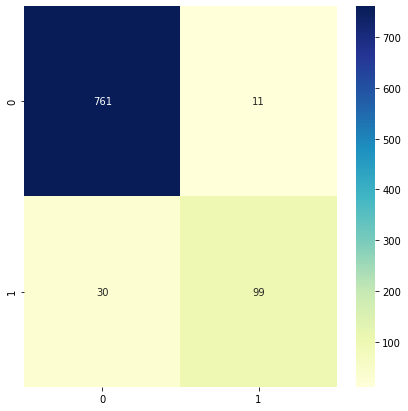

In [ ]:
# trainer.fit(model, train_loader, val_loader)
trainer.fit(model, train_loader, test_loader)

## Test

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loss:  0.6761940121650696
Accuracy: 0.9575623273849487
Precision: 0.7688022255897522
Recall: 0.7561643719673157
AUROC: 0.9376381635665894

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

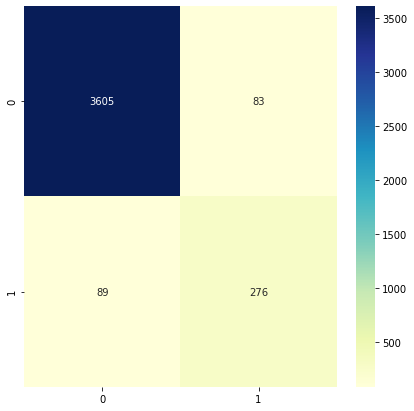

In [ ]:
trainer.test(test_dataloaders=val_loader)#, ckpt_path='latest.ckpt')

## Stop online logger

In [ ]:
exp_logger.experiment.stop()

# Mình không cài logger trong lightning module nhưng pl họ tự gọi log khi trainer có logger
# do đó cần xóa logger đi để tránh lỗi khi đã ngưng logger
trainer.logger=None

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 58 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 58 operations (0.00% done). Please wait.


All 58 operations synced, thanks for waiting!


# Hyper-parameters report

`exp001`: không hội tụ được

- batch size: 128
- **grad accumulate: 4**
- max epoch: 80
- **learning rate: 0.05**

`exp002`: exploding gradient at epoch 30th (?)
- batch size: 128
- grad accumulate: 1
- max epoch: 80
- **learning rate: 0.05**

Error report:
```
  Traceback (most recent call last):
    File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
      self.run()
    File "/usr/lib/python3.7/threading.py", line 870, in run
      self._target(*self._args, **self._kwargs)
    File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
      r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
    File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
      return _ForkingPickler.loads(res)
    File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
      fd = df.detach()
    File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
      with _resource_sharer.get_connection(self._id) as conn:
    File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
      c = Client(address, authkey=process.current_process().authkey)
    File "/usr/lib/python3.7/multiprocessing/connection.py", line 492, in Client
      c = SocketClient(address)
    File "/usr/lib/python3.7/multiprocessing/connection.py", line 620, in SocketClient
      s.connect(address)
  FileNotFoundError: [Errno 2] No such file or directory

  /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
    rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')
  Traceback (most recent call last):
    File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
      send_bytes(obj)
    File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
      self._send_bytes(m[offset:offset + size])
    File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
      self._send(header + buf)
    File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
      n = write(self._handle, buf)
  BrokenPipeError: [Errno 32] Broken pipe
```

`exp003`: Have a sign of convergence at epoch 40th, but as all experiments before, validation start to diverge too...
- batch size: 128
- grad accumulate: 1
- max epoch: 80
- learning rate: 0.025

`exp004`: fail to converge. User warning tại epoch cuối khi dùng SWA
- batch size: 128
- grad accumulate: 1
- max epoch: 80
- **learning rate: 0.01**
- **LR Schedule: CosineAnnealing + SWA**

`exp005`: có vẻ hội tụ tốt hơn Adam (từ epoch 20 là thấy)
- batch size: 128
- grad accumulate: 1
- max epoch: 80
- learning rate: 0.025
- **Optimizer: SGD**

# Evaluating model

## Visualize misclassified samples

In [ ]:
raise NotImplementedError()

# Inference on private set for submission

## Dataloader for private test set

In [ ]:
private_set = AICOVIDDataset(final_test_meta, torch.nn.ModuleList([transform0]))

In [ ]:
private_loader = torch.utils.data.DataLoader(
    private_set,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Inference

### Depricated

In [ ]:
# chunking = AudioChunking(400, 200)

In [ ]:
# preds = []

# for spec, _, _, _, _ in tqdm(private_set):
#     specs = chunking(spec)
#     pred = trainer.lightning_module.predict_step(specs, 0).max()
#     preds.append(pred.item())

# preds = np.array(preds)
# preds

100%|██████████| 1233/1233 [13:24<00:00,  1.53it/s]


array([9.94695659e-10, 8.88122575e-10, 1.90407619e-08, ...,
       6.66583292e-05, 9.98343694e-07, 6.44031564e-11])

In [ ]:
# preds = trainer.predict(dataloaders=private_loader)
# preds = np.array([ts.item() for ts in preds])
# preds

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([0, 0, 0, ..., 0, 0, 0])

### Segmentation and aggregate

In [ ]:
private_set = AICOVIDDataset(final_test_meta, torch.nn.ModuleList([transform0]), chunking=AudioChunking(400, 200))

In [ ]:
private_loader = torch.utils.data.DataLoader(
    private_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
preds = trainer.predict(dataloaders=private_loader)
preds = torch.cat(preds)
preds = preds.cpu().numpy()
preds

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([2.0623422e-05, 9.5908881e-06, 1.2448434e-03, ..., 7.4370287e-04,
       6.2988842e-01, 3.1544596e-01], dtype=float32)

In [ ]:
tmp_df = pd.DataFrame({'segment': private_set.idxs,
                          'assessment_result': preds})
preds = tmp_df.groupby(['segment']).max()['assessment_result']

### On raw

In [ ]:
private_set = AICOVIDDataset(final_test_meta, torch.nn.ModuleList([transform0]))

In [ ]:
private_loader = torch.utils.data.DataLoader(
    private_set,
    collate_fn=collate_pad_seq_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
preds = trainer.predict(dataloaders=private_loader)
preds = torch.cat(preds)
preds = preds.cpu().numpy()
preds

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([6.32742594e-05, 5.76850789e-10, 1.11760864e-14, ...,
       1.06937587e-02, 5.90009060e-29, 1.49623702e-09], dtype=float32)

# Lưu kết quả

In [ ]:
#@markdown Lưu lại model lên Google Drive
if train_mode:
  os.system('mkdir trained_models')
  compressed_name = f'{zip_name}_model.zip'
  torch.save(model.state_dict(), './trained_models/model_weights.pth')
  
  os.system(f'zip -j ./{compressed_name} ./trained_models/*')
  drive.Upload(compressed_name, model_zoo)

In [ ]:
#@markdown Lưu lại public test submission lên Google Drive
submit_df = pd.DataFrame({'uuid': final_test_meta['uuid'],
                          'assessment_result': preds})
submit_df.to_csv('results.csv', index=False)

# Nén file
os.system(f'zip -j ./{zip_name}.zip ./results.csv')

drive.Upload(zip_name+'.zip', submission_folder)

In [ ]:
#@markdown Lưu lại private test submission lên Google Drive
submit_df = pd.DataFrame({'uuid': private_test_meta['uuid'],
                          'assessment_result': preds})
submit_df.to_csv('results.csv', index=False)

# Nén file
os.system(f'zip -j ./{zip_name}_private_test.zip ./results.csv')

drive.Upload(zip_name+'_private_test.zip', submission_folder)

In [ ]:
#@markdown Load model lưu sẵn
if not train_mode:
  drive.Download(f'{zip_name}_model.zip', model_zoo)
  os.system(f'unzip -o {zip_name}_model.zip')
  model.load_state_dict(torch.load('model_weights.pth'))